In [115]:

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import requests
from io import StringIO

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import requests
from io import StringIO

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================================
# 1. CSV 파일 GitHub에서 직접 불러오기
# ============================================
url = "https://raw.githubusercontent.com/MyungKyuYi/HAR/main/Filtered_PPG_Data.csv"
response = requests.get(url)
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data)

# ============================================
# 2. 사용자별 시계열 병합 및 정규화
# ============================================
user_sequences = []
user_ids = []

# 사용자 그룹별 시계열 분리 및 정규화
for subject_id, group in df.groupby("subject"):
    sequence = group["PPG"].values
    sequence = (sequence - np.mean(sequence)) / (np.std(sequence) + 1e-6)
    user_sequences.append(sequence)
    user_ids.append(subject_id)

# 시계열 길이 맞추기 (최소 길이 기준)
min_len = min(len(seq) for seq in user_sequences)
user_sequences = [seq[:min_len] for seq in user_sequences]

# [num_users, 1, T] 형태로 변환
ppg_array = np.expand_dims(np.array(user_sequences), axis=1)  # (N, 1, T)

# ============================================
# 3. DataFrame으로 변환
# ============================================
# 사용자별 시계열 데이터를 DataFrame으로 변환 (사용자별로 시계열을 하나의 열로 합침)
df_ppg = pd.DataFrame(ppg_array.reshape(len(user_sequences), -1))  # 각 사용자의 시계열을 한 행으로

# 사용자 ID(subject)를 맨 앞에 추가
df_ppg.insert(0, 'subject', np.array(user_ids))  # subject 컬럼을 첫번째로 추가




Device: cpu


In [116]:
df_ppg.shape

(56, 11001)

In [117]:
new_df = df_ppg.copy()

In [118]:
hypertension_0 = {2, 5, 6, 10, 11, 12, 15, 19, 22, 24, 25, 28, 30, 40, 47, 48, 49, 50, 51}
hypertension_2 = {7, 8, 13, 14, 16, 18, 20, 26, 27, 35, 41, 42, 43, 44, 45, 46}
hypertension_1 = {1, 3, 4, 9, 17, 21, 23, 29, 31, 32, 33, 34, 36, 37, 38, 39, 52, 53, 54, 55, 56}

new_df.loc[new_df['subject'].isin(hypertension_0), 'Hypertension'] = 0
new_df.loc[new_df['subject'].isin(hypertension_2), 'Hypertension'] = 2
new_df.loc[new_df['subject'].isin(hypertension_1), 'Hypertension'] = 1

# 결과 출력
new_df['Hypertension'].value_counts()

,count
Hypertension,
1.0,21
0.0,19
2.0,16


In [119]:
# 훈련 데이터 subject 목록
#train_subjects = [2, 5, 6, 10, 11, 12, 15, 19, 22, 24, 25, 28, 30, 40, 47, 48, 49, 50, 51]
train_subjects = [2, 10, 11, 12, 15, 19, 22, 24, 25, 28, 30, 40, 47]

# 훈련 데이터 (subject가 train_subjects에 포함된 데이터)
train_df = new_df[new_df['subject'].isin(train_subjects)]

# 테스트 데이터 (subject가 train_subjects에 포함되지 않고, 37, 42가 아닌 데이터)
#excluded_subjects = [37, 42]
#test_df = new_df[~new_df['subject'].isin(train_subjects + excluded_subjects)]
test_df = new_df[~new_df['subject'].isin(train_subjects)]

In [120]:
train_df['Hypertension'].value_counts()

,count
Hypertension,
0.0,13


In [121]:
test_df['Hypertension'].value_counts()

,count
Hypertension,
1.0,21
2.0,16
0.0,6


In [122]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def timestep_embedding(timesteps, dim, max_period=1000, repeat_only=False):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                        These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    if not repeat_only:
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period)
            * torch.arange(start=0, end=half, dtype=torch.float32)
            / half
        ).to(device=timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
    else:
        embedding = repeat(timesteps, "b -> b d", d=dim)
    return embedding


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


class TimestepBlock(nn.Module):
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """
        raise NotImplementedError

class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb, context=None):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)  # Pass emb to TimestepBlock layers
            else:
                x = layer(x)  # Regular layers do not receive emb
        return x

def Normalize(in_channels):
    return nn.GroupNorm(
        num_groups=32, num_channels=in_channels, eps=1e-6, affine=True
    )


def count_flops_attn(model, _x, y):
    """
    A counter for the `thop` package to count the operations in an
    attention operation.
    Meant to be used like:
        macs, params = thop.profile(
            model,
            inputs=(inputs, timestamps),
            custom_ops={QKVAttention: QKVAttention.count_flops},
        )
    """
    b, c, *spatial = y[0].shape
    num_spatial = int(np.prod(spatial))
    # We perform two matmuls with the same number of ops.
    # The first computes the weight matrix, the second computes
    # the combination of the value vectors.
    matmul_ops = 2 * b * (num_spatial**2) * c
    model.total_ops += th.DoubleTensor([matmul_ops])


class QKVAttentionLegacy(nn.Module):
    """
    A module which performs QKV attention.
    Matches legacy QKVAttention + input/ouput heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(
            ch, dim=1
        )
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert channels % num_head_channels == 0, (
                f"q,k,v channels {channels} is "
                f"not divisible by num_head_channels {num_head_channels}"
            )
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = Normalize(channels)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(nn.Conv1d(channels, channels, 1))

    def forward(self, x):
        return self._forward(
            x,
        )

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv1d(
                self.channels, self.out_channels, 3, stride=2, padding=padding
            )#TODO:Mudar
        else:
            assert self.channels == self.out_channels
            self.op = nn.AvgPool1d(kernel_size=2, stride=2)#TODO: Mudar

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv1d(
                self.channels, self.out_channels, 3, padding=padding
            )#TODO:Mudar

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class ResBlock(TimestepBlock):  # Ensure ResBlock inherits from TimestepBlock
    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            Normalize(channels),
            nn.SiLU(),
            nn.Conv1d(channels, self.out_channels, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False)
            self.x_upd = Upsample(channels, False)
        elif down:
            self.h_upd = Downsample(channels, False)
            self.x_upd = Downsample(channels, False)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_channels,
                2 * self.out_channels
                if use_scale_shift_norm
                else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            Normalize(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                nn.Conv1d(self.out_channels, self.out_channels, 3, padding=1)
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = nn.Conv1d(
                channels, self.out_channels, kernel_size=1
            )
        else:
            self.skip_connection = nn.Conv1d(channels, self.out_channels, kernel_size=1)

    def forward(self, x, emb):
        """
        Apply the ResBlock to `x` with timestep embeddings `emb`.
        """
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)

        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]

        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)

        return self.skip_connection(x) + h

class UNetModel(nn.Module):
    def __init__(
        self,
        image_size=32,
        in_channels=1,
        model_channels=32,
        out_channels=1,
        num_res_blocks=2,
        attention_resolutions=[16, 8],
        dropout=0.1,
        channel_mult=(2, 4, 8),
        num_heads=4,
        use_scale_shift_norm=False,
        resblock_updown=True,
    ):
        super().__init__()

        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.num_heads = num_heads
        self.use_scale_shift_norm = use_scale_shift_norm
        self.resblock_updown = resblock_updown

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.input_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv1d(in_channels, model_channels, 3, padding=1))
        ])
        input_block_chans = [model_channels]
        ch = model_channels
        ds = 1

        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResBlock(ch, time_embed_dim, dropout, out_channels=mult * model_channels, use_scale_shift_norm=use_scale_shift_norm)]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(TimestepEmbedSequential(Downsample(ch, True, out_channels=out_ch)))
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResBlock(ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm),
            AttentionBlock(ch, num_heads=num_heads),
            ResBlock(ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm),
        )

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [ResBlock(ch + ich, time_embed_dim, dropout, out_channels=model_channels * mult, use_scale_shift_norm=use_scale_shift_norm)]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(Upsample(ch, True, out_channels=out_ch))
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            Normalize(ch),
            nn.SiLU(),
            zero_module(nn.Conv1d(ch, out_channels, 3, padding=1)),
        )

    def forward(self, x, timesteps=None, context=None, y=None):
        assert timesteps is not None, "timesteps must be provided"
        hs = []
        t_emb = timestep_embedding(timesteps, self.model_channels, repeat_only=False)
        emb = self.time_embed(t_emb)

        h = x
        for module in self.input_blocks:
            h = module(h, emb, context)
            hs.append(h)
        h = self.middle_block(h, emb, context)

        for module in self.output_blocks:
            h_pop = hs.pop()
            if h.shape[2] != h_pop.shape[2]:
                h_pop = F.interpolate(h_pop, size=h.shape[2], mode='nearest')
            h = torch.cat([h, h_pop], dim=1)
            h = module(h, emb, context)

        return self.out(h)


from functools import partial
from inspect import isfunction

import numpy as np
import torch as th

def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(
        shape[0], *((1,) * (len(shape) - 1))
    )
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()


def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def make_beta_schedule(
    schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3
):
    if schedule == "linear":
        betas = (
            torch.linspace(
                linear_start**0.5,
                linear_end**0.5,
                n_timestep,
                dtype=torch.float64,
            )
            ** 2
        )

    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) / n_timestep
            + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * np.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = np.clip(betas, a_min=0, a_max=0.999)

    elif schedule == "sqrt_linear":
        betas = torch.linspace(
            linear_start, linear_end, n_timestep, dtype=torch.float64
        )
    elif schedule == "sqrt":
        betas = (
            torch.linspace(
                linear_start, linear_end, n_timestep, dtype=torch.float64
            )
            ** 0.5
        )
    else:
        raise ValueError(f"schedule '{schedule}' unknown.")
    return betas.numpy()

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from functools import partial

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

class DDIM(nn.Module):
    def __init__(
        self,
        unet_config,
        timesteps=1000,
        ddim_steps=50,
        beta_schedule="linear",
        clip_denoised=False,
        linear_start=1e-4,
        linear_end=2e-2,
        original_elbo_weight=0.0,
        parameterization="eps",
    ):
        super().__init__()
        assert parameterization in ["eps", "x0"], 'Only "eps" and "x0" are supported.'
        self.parameterization = parameterization
        self.model = UNetModel(**unet_config.get("params", {}))
        self.clip_denoised = clip_denoised
        self.original_elbo_weight = original_elbo_weight
        self.ddim_steps = ddim_steps
        self.register_schedule(beta_schedule, timesteps, linear_start, linear_end)

    def register_schedule(self, beta_schedule, timesteps, linear_start, linear_end):
        betas = np.linspace(linear_start, linear_end, timesteps, dtype=np.float64)
        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        self.num_timesteps = int(timesteps)
        to_torch = partial(torch.tensor, dtype=torch.float32)

        self.register_buffer("betas", to_torch(betas))
        self.register_buffer("alphas_cumprod", to_torch(alphas_cumprod))
        self.register_buffer("alphas_cumprod_prev", to_torch(alphas_cumprod_prev))
        self.register_buffer("sqrt_recip_alphas_cumprod", to_torch(np.sqrt(1.0 / alphas_cumprod)))
        self.register_buffer("sqrt_one_minus_alphas_cumprod", to_torch(np.sqrt(1.0 - alphas_cumprod)))

    def ddim_sample(self, x, t, eta=0.0):
        model_output = self.model(x, t)

        if self.parameterization == "eps":
            pred_x0 = extract(self.sqrt_recip_alphas_cumprod, t, x.shape) * x - \
                        extract(self.sqrt_one_minus_alphas_cumprod, t, x.shape) * model_output
        else:
            pred_x0 = model_output

        if self.clip_denoised:
            pred_x0 = torch.clamp(pred_x0, -1.0, 1.0)

        sigma = eta * (1 - extract(self.alphas_cumprod, t, x.shape)).sqrt()
        noise = torch.randn_like(x)

        return pred_x0 + sigma * noise

    @torch.no_grad()
    def p_sample_loop_ddim(self, shape, eta=0.0):
        device = self.betas.device
        img = torch.randn(shape, device=device)

        for i in tqdm(reversed(range(0, self.ddim_steps)), desc="DDIM sampling"):
            t = torch.full((shape[0],), i, device=device, dtype=torch.long)
            img = self.ddim_sample(img, t, eta)

        return img

    @torch.no_grad()
    def sample(self, batch_size=16, eta=0.0):
        image_size = self.model.image_size
        channels = self.model.in_channels
        return self.p_sample_loop_ddim((batch_size, channels, image_size), eta=eta)

    def forward(self, x, t):
        return self.model(x, t)

In [123]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

# 'subject' 열 제거
train_df_no_subject = train_df.drop(columns=['subject', 'Hypertension'])

# 텐서로 변환
train_data_tensor = torch.tensor(train_df_no_subject.values, dtype=torch.float32)

# TensorDataset 및 DataLoader 생성
train_dataset = TensorDataset(train_data_tensor)  # 레이블 없음
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [124]:
import os
import torch
from torch import optim # Import optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import torch.nn as nn
import torch.nn.functional as F
import math

# 학습 함수
def train_ddim_model(model, train_loader, num_epochs=20, learning_rate=1e-4, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            x = batch[0].to(device)  # 레이블이 없으므로 x만 가져옴
            # x = x.unsqueeze(1)  # Remove this line - it's causing the error

            # Reshape x to have the expected shape (batch_size, in_channels, image_size)
            x = x.view(x.shape[0], unet_config["params"]["in_channels"], -1)
            t = torch.randint(0, model.num_timesteps, (x.shape[0],), device=device).long()

            optimizer.zero_grad()
            loss = loss_fn(model(x, t), x)  # 모델의 출력과 입력 비교 (재구성 손실)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}: Avg Train Loss = {avg_loss:.4f}")

# 모델 초기화
device = 'cuda' if torch.cuda.is_available() else 'cpu'

unet_config = {
    "params": {
        "image_size": 11000,          # 시퀀스 길이 그대로 사용
        "in_channels": 1,          # 1채널 입력 (기본적인 경우)
        "model_channels": 32,
        "out_channels": 1,
        "num_res_blocks": 2,
        "attention_resolutions": [13],  # 52를 downsample했을 때 포함되는 해상도
        "dropout": 0.1,
        "channel_mult": (2, 4, 8),
        "num_heads": 4,
        "use_scale_shift_norm": False,
        "resblock_updown": True,
    }
}

ddim_model = DDIM(unet_config=unet_config, timesteps=2000, ddim_steps=1000, parameterization='eps').to(device)

# 학습 시작
train_ddim_model(ddim_model, ppg_loader, num_epochs=50, learning_rate=1e-4, device=device)

Epoch 1/50: 100%|██████████| 2/2 [00:08<00:00,  4.24s/it]


Epoch 1: Avg Train Loss = 0.9923


Epoch 2/50: 100%|██████████| 2/2 [00:07<00:00,  3.55s/it]


Epoch 2: Avg Train Loss = 0.9590


Epoch 3/50: 100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


Epoch 3: Avg Train Loss = 0.9204


Epoch 4/50: 100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


Epoch 4: Avg Train Loss = 0.8831


Epoch 5/50: 100%|██████████| 2/2 [00:07<00:00,  3.91s/it]


Epoch 5: Avg Train Loss = 0.8406


Epoch 6/50: 100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Epoch 6: Avg Train Loss = 0.7976


Epoch 7/50: 100%|██████████| 2/2 [00:07<00:00,  3.95s/it]


Epoch 7: Avg Train Loss = 0.7606


Epoch 8/50: 100%|██████████| 2/2 [00:07<00:00,  3.91s/it]


Epoch 8: Avg Train Loss = 0.7177


Epoch 9/50: 100%|██████████| 2/2 [00:08<00:00,  4.03s/it]


Epoch 9: Avg Train Loss = 0.6769


Epoch 10/50: 100%|██████████| 2/2 [00:07<00:00,  3.87s/it]


Epoch 10: Avg Train Loss = 0.6401


Epoch 11/50: 100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Epoch 11: Avg Train Loss = 0.6007


Epoch 12/50: 100%|██████████| 2/2 [00:07<00:00,  3.91s/it]


Epoch 12: Avg Train Loss = 0.5667


Epoch 13/50: 100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


Epoch 13: Avg Train Loss = 0.5329


Epoch 14/50: 100%|██████████| 2/2 [00:06<00:00,  3.46s/it]


Epoch 14: Avg Train Loss = 0.4973


Epoch 15/50: 100%|██████████| 2/2 [00:07<00:00,  3.88s/it]


Epoch 15: Avg Train Loss = 0.4697


Epoch 16/50: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Epoch 16: Avg Train Loss = 0.4377


Epoch 17/50: 100%|██████████| 2/2 [00:07<00:00,  3.88s/it]


Epoch 17: Avg Train Loss = 0.4182


Epoch 18/50: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Epoch 18: Avg Train Loss = 0.3748


Epoch 19/50: 100%|██████████| 2/2 [00:07<00:00,  3.87s/it]


Epoch 19: Avg Train Loss = 0.3592


Epoch 20/50: 100%|██████████| 2/2 [00:07<00:00,  3.76s/it]


Epoch 20: Avg Train Loss = 0.3465


Epoch 21/50: 100%|██████████| 2/2 [00:06<00:00,  3.49s/it]


Epoch 21: Avg Train Loss = 0.3165


Epoch 22/50: 100%|██████████| 2/2 [00:07<00:00,  3.89s/it]


Epoch 22: Avg Train Loss = 0.3003


Epoch 23/50: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Epoch 23: Avg Train Loss = 0.2621


Epoch 24/50: 100%|██████████| 2/2 [00:07<00:00,  3.95s/it]


Epoch 24: Avg Train Loss = 0.2579


Epoch 25/50: 100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Epoch 25: Avg Train Loss = 0.2439


Epoch 26/50: 100%|██████████| 2/2 [00:07<00:00,  3.93s/it]


Epoch 26: Avg Train Loss = 0.2220


Epoch 27/50: 100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


Epoch 27: Avg Train Loss = 0.2074


Epoch 28/50: 100%|██████████| 2/2 [00:07<00:00,  3.51s/it]


Epoch 28: Avg Train Loss = 0.1835


Epoch 29/50: 100%|██████████| 2/2 [00:08<00:00,  4.00s/it]


Epoch 29: Avg Train Loss = 0.1749


Epoch 30/50: 100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


Epoch 30: Avg Train Loss = 0.1491


Epoch 31/50: 100%|██████████| 2/2 [00:07<00:00,  3.94s/it]


Epoch 31: Avg Train Loss = 0.1499


Epoch 32/50: 100%|██████████| 2/2 [00:07<00:00,  3.60s/it]


Epoch 32: Avg Train Loss = 0.1321


Epoch 33/50: 100%|██████████| 2/2 [00:07<00:00,  3.77s/it]


Epoch 33: Avg Train Loss = 0.1306


Epoch 34/50: 100%|██████████| 2/2 [00:07<00:00,  3.96s/it]


Epoch 34: Avg Train Loss = 0.1191


Epoch 35/50: 100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


Epoch 35: Avg Train Loss = 0.1022


Epoch 36/50: 100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


Epoch 36: Avg Train Loss = 0.0956


Epoch 37/50: 100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


Epoch 37: Avg Train Loss = 0.0919


Epoch 38/50: 100%|██████████| 2/2 [00:07<00:00,  3.96s/it]


Epoch 38: Avg Train Loss = 0.0796


Epoch 39/50: 100%|██████████| 2/2 [00:07<00:00,  3.76s/it]


Epoch 39: Avg Train Loss = 0.0743


Epoch 40/50: 100%|██████████| 2/2 [00:07<00:00,  3.64s/it]


Epoch 40: Avg Train Loss = 0.0653


Epoch 41/50: 100%|██████████| 2/2 [00:07<00:00,  3.94s/it]


Epoch 41: Avg Train Loss = 0.0626


Epoch 42/50: 100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


Epoch 42: Avg Train Loss = 0.0579


Epoch 43/50: 100%|██████████| 2/2 [00:07<00:00,  3.95s/it]


Epoch 43: Avg Train Loss = 0.0538


Epoch 44/50: 100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


Epoch 44: Avg Train Loss = 0.0479


Epoch 45/50: 100%|██████████| 2/2 [00:07<00:00,  3.95s/it]


Epoch 45: Avg Train Loss = 0.0437


Epoch 46/50: 100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


Epoch 46: Avg Train Loss = 0.0395


Epoch 47/50: 100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


Epoch 47: Avg Train Loss = 0.0299


Epoch 48/50: 100%|██████████| 2/2 [00:07<00:00,  3.99s/it]


Epoch 48: Avg Train Loss = 0.0286


Epoch 49/50: 100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


Epoch 49: Avg Train Loss = 0.0284


Epoch 50/50: 100%|██████████| 2/2 [00:07<00:00,  3.98s/it]

Epoch 50: Avg Train Loss = 0.0234


In [125]:
test_df.shape

(43, 11002)

In [126]:
# test_df에 subject 컬럼이 있다고 가정
test_data_tensor = torch.tensor(test_df.drop(columns=["Hypertension", "subject"]).values, dtype=torch.float32).unsqueeze(1)
test_labels_tensor = torch.tensor(test_df["Hypertension"].values, dtype=torch.float32).unsqueeze(-1)
subject_tensor = torch.tensor(test_df["subject"].values, dtype=torch.int32).unsqueeze(-1)

# subject 추가 포함
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor, subject_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [160]:
import torch
import torch.nn.functional as F
import pandas as pd

import torch.nn.functional as F
import pandas as pd

def test_ddpm(ddpm, test_loader, device):
    ddpm.eval()
    total_loss = 0
    num_samples = 0
    all_reconstruction_errors = []
    true_labels = []
    subject_ids = []

    with torch.no_grad():
        for batch in test_loader:
            x, labels, subjects = batch
            x = x.to(device)
            labels = labels.to(device)

            t = torch.zeros(x.size(0), dtype=torch.long).to(device)  # time step 고정
            reconstructed_x = ddpm(x, t)

            # shape mismatch 방지
            min_len = min(x.shape[2], reconstructed_x.shape[2])
            x = x[:, :, :min_len]
            reconstructed_x = reconstructed_x[:, :, :min_len]

            # 🔁 MSE(Mean Squared Error) 기반 reconstruction error 계산
            reconstruction_error = F.mse_loss(reconstructed_x, x, reduction='none').mean(dim=[1, 2])
            loss = reconstruction_error.mean()

            total_loss += loss.item() * x.size(0)
            num_samples += x.size(0)

            all_reconstruction_errors.extend(reconstruction_error.cpu().numpy().tolist())
            true_labels.extend(labels.cpu().numpy().flatten().tolist())
            subject_ids.extend(subjects.cpu().numpy().flatten().tolist())

    avg_loss = total_loss / num_samples
    anomaly_df = pd.DataFrame({
        "Subject": subject_ids,
        "True_Label": true_labels,
        "Reconstruction_Error": all_reconstruction_errors
    })

    print(f"✅ 최종 테스트 손실 (MSE 기반): {avg_loss:.4f}")
    return anomaly_df, avg_loss, None



# 실행 코드 블록
if __name__ == "__main__":

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 테스트 실행
    anomaly_df, test_loss, _ = test_ddpm(ddim_model, test_loader, device)

    # 결과 출력
    print("\n📋 테스트 결과 상위 5개:")
    print(anomaly_df.head())

    print(f"\n✅ Test Loss (MAE): {test_loss:.4f}")

Using device: cpu
✅ 최종 테스트 손실 (MSE 기반): 0.0228

📋 테스트 결과 상위 5개:
   Subject  True_Label  Reconstruction_Error
0        1         1.0              0.024904
1        3         1.0              0.024932
2        4         1.0              0.026193
3        5         0.0              0.022724
4        6         0.0              0.023711

✅ Test Loss (MAE): 0.0228


In [161]:
anomaly_df

,Subject,True_Label,Reconstruction_Error
0,1,1.0,0.024904
1,3,1.0,0.024932
2,4,1.0,0.026193
3,5,0.0,0.022724
4,6,0.0,0.023711
5,7,2.0,0.023569
6,8,2.0,0.025737
7,9,1.0,0.021655
8,13,2.0,0.022986
9,14,2.0,0.021533


In [162]:
anomaly_df['True_Label'].value_counts()

,count
True_Label,
1.0,21
2.0,16
0.0,6


In [163]:
# 레이블별 최소값과 최대값 계산
group_stats = anomaly_df.groupby("True_Label")["Reconstruction_Error"].agg(["min", "max"]).reset_index()

# 출력
print("Reconstruction_Error - Min/Max by True Label")
for _, row in group_stats.iterrows():
    label = row["True_Label"]
    min_val = row["min"]
    max_val = row["max"]
    print(f"Label {label}: min = {min_val:.4f}, max = {max_val:.4f}")

Reconstruction_Error - Min/Max by True Label
Label 0.0: min = 0.0190, max = 0.0237
Label 1.0: min = 0.0158, max = 0.0268
Label 2.0: min = 0.0177, max = 0.0259


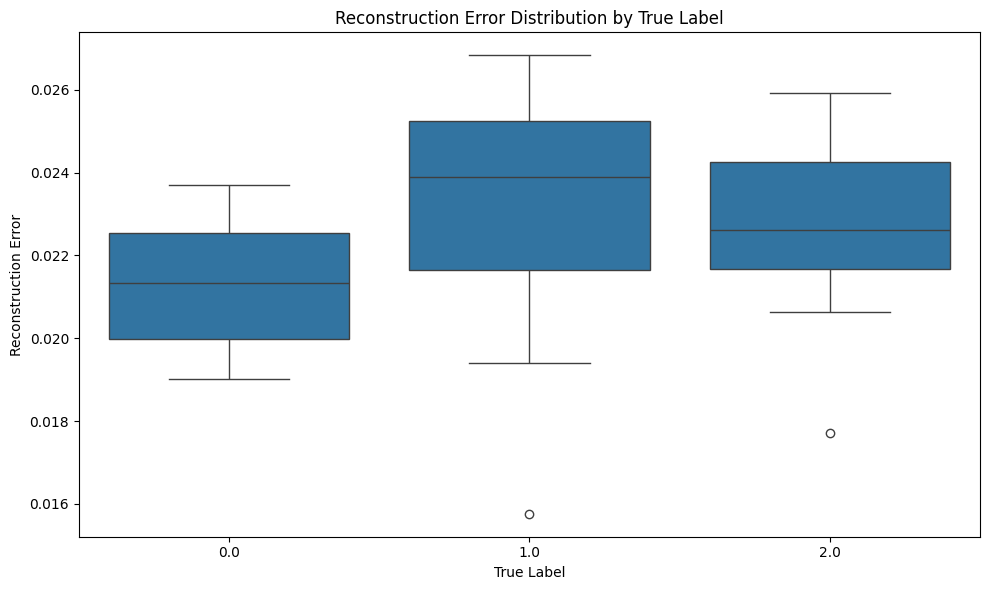

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 기본 폰트를 'DejaVu Sans'로 변경
rcParams['font.family'] = 'DejaVu Sans'

plt.figure(figsize=(10, 6))

# True_Label 별로 Reconstruction_Error의 범위를 박스플롯으로 시각화
sns.boxplot(x='True_Label', y='Reconstruction_Error', data=anomaly_df)

plt.title('Reconstruction Error Distribution by True Label')
plt.xlabel('True Label')
plt.ylabel('Reconstruction Error')
plt.tight_layout()

plt.show()


In [186]:
threshold = 0.022

In [187]:
anomaly_df.columns

Index(['Subject', 'True_Label', 'Reconstruction_Error', 'Binary_Label'], dtype='object')

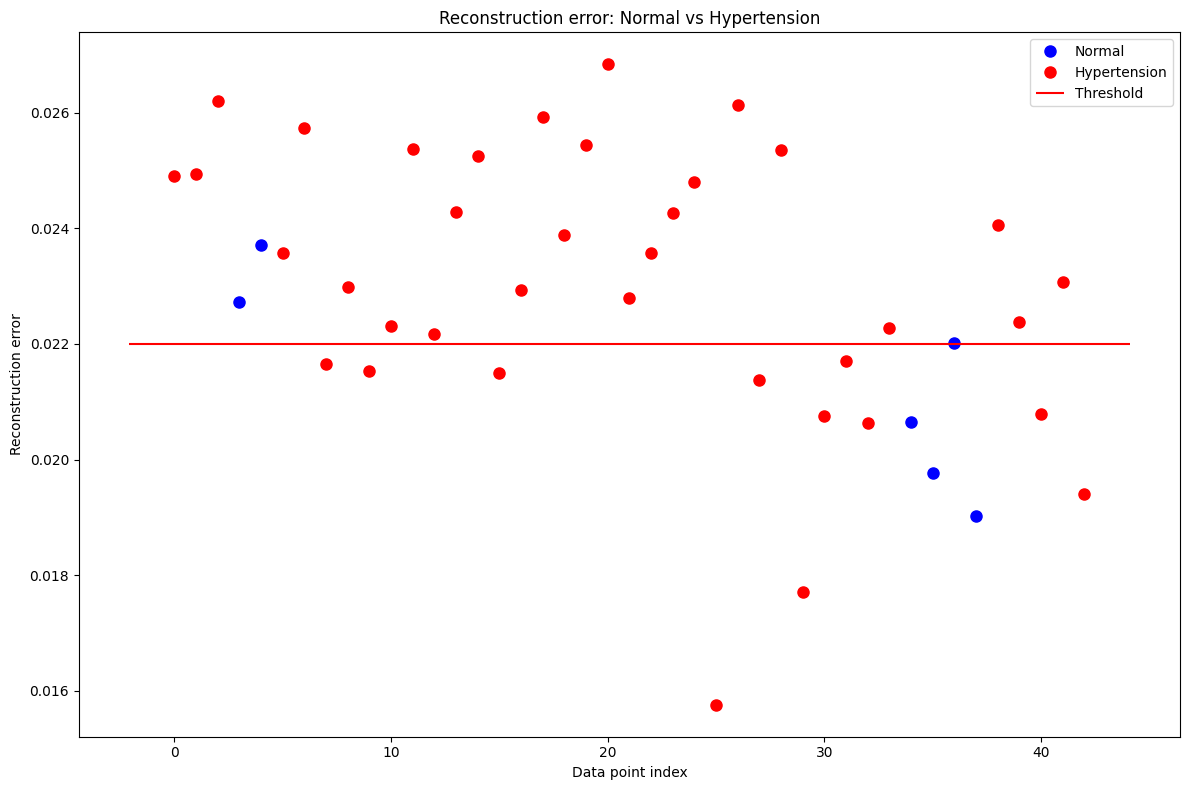

In [194]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# True_Label이 0.0이면 Normal, 나머지 Hypertension으로 라벨링
anomaly_df['Binary_Label'] = anomaly_df['True_Label'].apply(lambda x: 0 if x == 0.0 else 1)

# 이분화된 레이블 기준으로 그룹화
groups = anomaly_df.groupby('Binary_Label')

# 시각화
fig, ax = plt.subplots(figsize=(12, 8))  # 박스를 더 크게 설정

for name, group in groups:
    label = "Normal" if name == 0 else "Hypertension"  # name == 0이면 Normal, 나머지는 Hypertension
    # Normal은 파란색 큰 원, Hypertension은 빨간색 큰 원
    color = 'blue' if name == 0 else 'red'
    ax.plot(group.index, group.Reconstruction_Error, marker='o', ms=8, linestyle='', color=color, label=label)

# threshold 값 위와 아래의 subject 번호 표시
above_threshold = anomaly_df[anomaly_df['Reconstruction_Error'] > threshold]
below_threshold = anomaly_df[anomaly_df['Reconstruction_Error'] <= threshold]

# threshold 위의 subject 번호 표시 (번호 제외)
for i, row in above_threshold.iterrows():
    ax.text(i, row.Reconstruction_Error + 0.002, '', fontsize=10, fontweight='bold', rotation=45, ha='center', color='black')

# threshold 아래의 subject 번호 표시 (번호 제외)
for i, row in below_threshold.iterrows():
    ax.text(i, row.Reconstruction_Error - 0.002, '', fontsize=10, fontweight='bold', rotation=45, ha='center', color='black')

# threshold 선 추가
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

# 범례 및 라벨
ax.legend()
plt.title("Reconstruction error: Normal vs Hypertension")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.tight_layout()
plt.show()




In [197]:
# threshold 값 위와 아래의 subject 번호 출력
above_threshold_normal = anomaly_df[(anomaly_df['Reconstruction_Error'] > threshold) & (anomaly_df['Binary_Label'] == 0)]
below_threshold_normal = anomaly_df[(anomaly_df['Reconstruction_Error'] <= threshold) & (anomaly_df['Binary_Label'] == 0)]

above_threshold_hypertension = anomaly_df[(anomaly_df['Reconstruction_Error'] > threshold) & (anomaly_df['Binary_Label'] == 1)]
below_threshold_hypertension = anomaly_df[(anomaly_df['Reconstruction_Error'] <= threshold) & (anomaly_df['Binary_Label'] == 1)]

# 출력
print("Normal subjects above threshold:")
print(above_threshold_normal['Subject'].values)

print("Normal subjects below threshold:")
print(below_threshold_normal['Subject'].values)

print("Hypertension subjects above threshold:")
print(above_threshold_hypertension['Subject'].values)

print("Hypertension subjects below threshold:")
print(below_threshold_hypertension['Subject'].values)



Normal subjects above threshold:
[ 5  6 50]
Normal subjects below threshold:
[48 49 51]
Hypertension subjects above threshold:
[ 1  3  4  7  8 13 16 17 18 20 21 26 27 29 31 32 33 34 35 36 38 41 46 52
 53 55]
Hypertension subjects below threshold:
[ 9 14 23 37 39 42 43 44 45 54 56]


In [198]:
# Normal과 Hypertension에 해당하는 subject 번호 나열
normal_subjects = anomaly_df[anomaly_df['Binary_Label'] == 0]['Subject'].values
hypertension_subjects = anomaly_df[anomaly_df['Binary_Label'] == 1]['Subject'].values

# 출력
print("Normal subjects:")
print(normal_subjects)

print("Hypertension subjects:")
print(hypertension_subjects)


Normal subjects:
[ 5  6 48 49 50 51]
Hypertension subjects:
[ 1  3  4  7  8  9 13 14 16 17 18 20 21 23 26 27 29 31 32 33 34 35 36 37
 38 39 41 42 43 44 45 46 52 53 54 55 56]


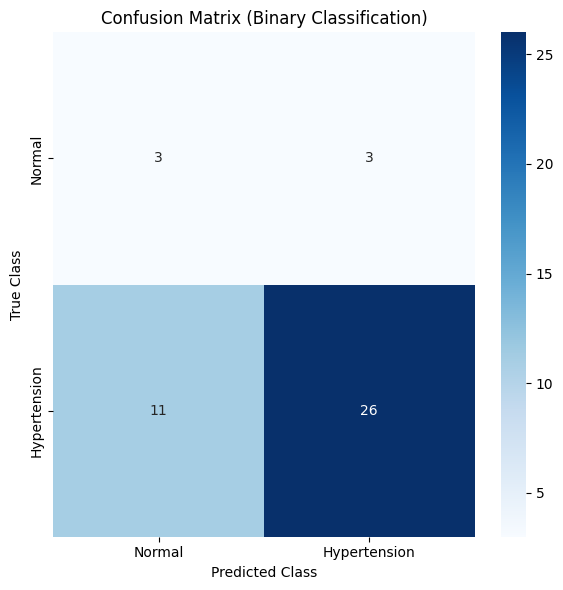

Accuracy: 0.6744
Precision: 0.8966
Recall: 0.7027
F1 Score: 0.7879


In [199]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# 1. True_Label을 이진화: 0.0 → 0 ("Normal"), 그 외 → 1 ("Hypertension")
anomaly_df['Binary_Label'] = anomaly_df['True_Label'].apply(lambda x: 0 if x == 0.0 else 1)

# 2. 예측값: 임계값 초과 시 비정상(1), 이하이면 정상(0)
y_true = anomaly_df['Binary_Label'].values
y_pred = [1 if e > threshold else 0 for e in anomaly_df['Reconstruction_Error'].values]

# 3. 혼동 행렬
LABELS = ["Normal", "Hypertension"]
conf_matrix = confusion_matrix(y_true, y_pred)

# 4. 시각화
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=LABELS, yticklabels=LABELS, cmap="Blues")
plt.title("Confusion Matrix (Binary Classification)")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()

# 5. 평가 지표 계산
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 6. 평가 지표 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

